# IEOR4578: Online Retail Forecasting Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from datetime import date, timedelta
import holidays

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Part 1: Import Data, Data Pre-processing, and EDA

In [2]:
file_path = 'online_retail_II.xlsx'
data = pd.read_excel(file_path, sheet_name=None)

In [3]:
# since the excel file contains two spreadsheets, we concat them together to get the entire dataset
sheet1 = data['Year 2009-2010']
sheet2 = data['Year 2010-2011']
df = pd.concat([sheet1, sheet2], axis=0)
df = df[df["Country"]=="United Kingdom"]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom


In [4]:
# create a new column sales amount
df['Sales'] = df['Quantity']*df['Price']

# create a new column date to for calculating daily sales
df['Date'] = pd.to_datetime(df['InvoiceDate']).dt.date

daily_sales = df.groupby(['Date'])['Sales'].sum().reset_index()
daily_sales

,Date,Sales
0,2009-12-01,46692.71
1,2009-12-02,55871.42
2,2009-12-03,67340.80
3,2009-12-04,37828.33
4,2009-12-05,9042.36
...,...,...
599,2011-12-05,54715.25
600,2011-12-06,50307.31
601,2011-12-07,55028.58
602,2011-12-08,78437.90


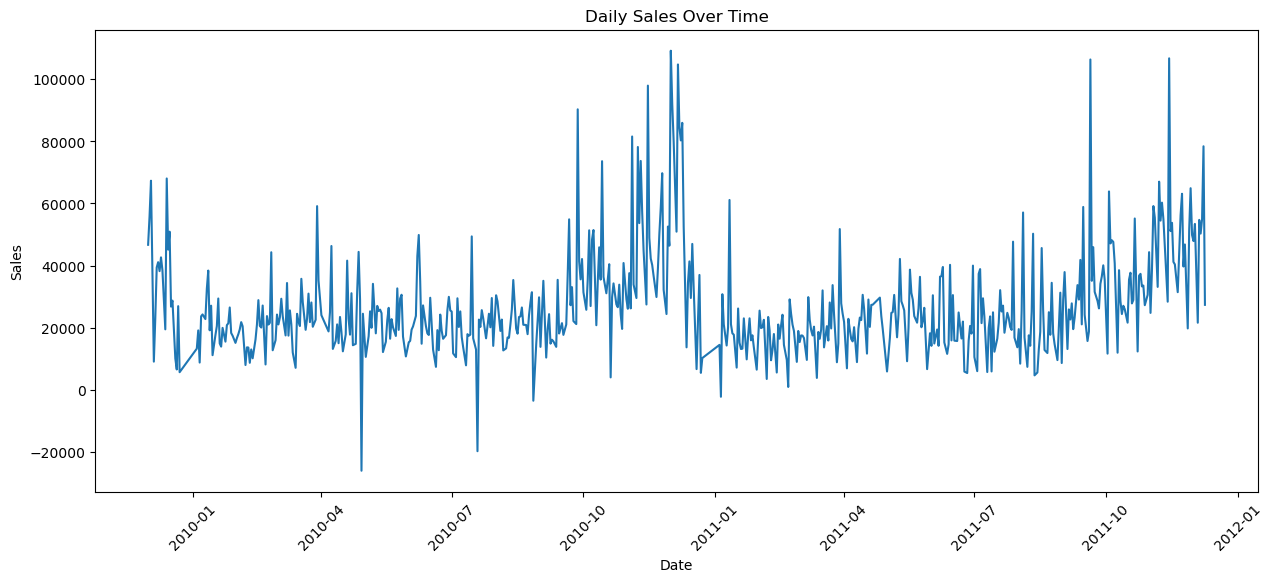

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

In [6]:
# create a new column month & year to account for potential seasonality
daily_sales['Month'] = pd.to_datetime(daily_sales['Date']).dt.month
daily_sales['Year'] = pd.to_datetime(daily_sales['Date']).dt.year
daily_sales['Weekday'] = pd.to_datetime(daily_sales['Date']).dt.day_name()

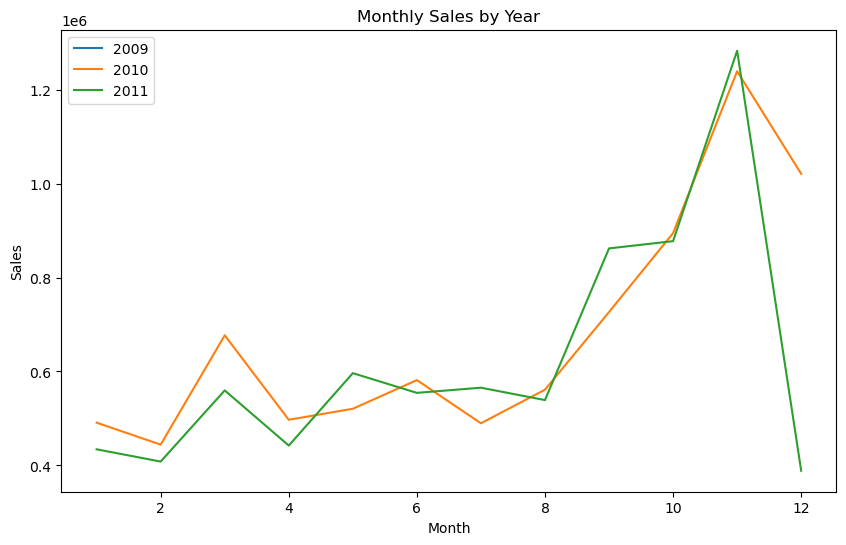

In [7]:
monthly_sales = daily_sales.groupby(['Year','Month'])['Sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
years = sorted(monthly_sales['Year'].unique())
for y in years:
    yd = monthly_sales[monthly_sales['Year']==y]
    plt.plot(yd['Month'], yd['Sales'],label = str(y))
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales by Year')
plt.legend()
plt.show()

COMMENT:

Seasonality! More monthly sales when approaching to holiday seasons (Oct-Dec).

For year 2011 (the green line), monthly sales drops in the Dec. This makes sense because we only have the sales data up to 12/09/2011.

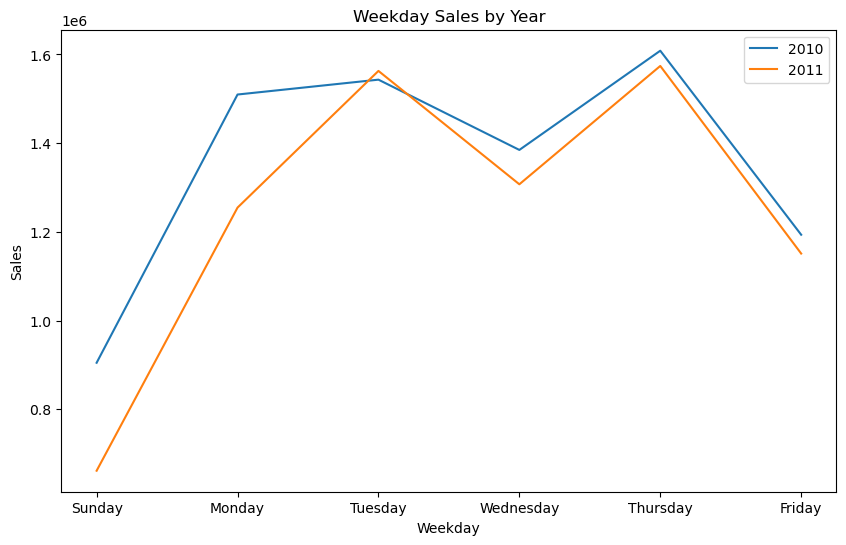

In [8]:
week_sales = daily_sales.groupby(['Year','Weekday'])['Sales'].sum().reset_index()
weekdays = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

plt.figure(figsize=(10, 6))
for y in [2010,2011]:
    yd = week_sales[week_sales['Year']==y]
    yd = yd.set_index('Weekday').reindex(weekdays).reset_index()
    plt.plot(yd['Weekday'], yd['Sales'],label = str(y))
plt.xlabel('Weekday')
plt.ylabel('Sales')
plt.title('Weekday Sales by Year')
plt.legend()
plt.show()

In [9]:
print(df[['Sales']].describe())

               Sales
count  981330.000000
mean       16.694266
std       303.033401
min   -168469.600000
25%         3.350000
50%         8.470000
75%        16.950000
max    168469.600000


In [10]:
daily_sales.head(3)

,Date,Sales,Month,Year,Weekday
0,2009-12-01,46692.71,12,2009,Tuesday
1,2009-12-02,55871.42,12,2009,Wednesday
2,2009-12-03,67340.80,12,2009,Thursday


## Part 2: Adding Relevant Features & Feature Engineering

(1). Adding UK Holidays as a feature

In [11]:
start_date = date(2009, 12, 1)
end_date = date(2011, 12, 9)

date_holiday = []
uk_holidays = holidays.UnitedKingdom()

current_date = start_date
while current_date <= end_date:
    holiday = 1 if current_date in uk_holidays else 0
    date_holiday.append([current_date, holiday])
    current_date += timedelta(days=1)

df_holidays = pd.DataFrame(date_holiday, columns=['Date', 'Holiday'])

daily_sales = pd.merge(daily_sales, df_holidays, on="Date")
daily_sales.head(3)

,Date,Sales,Month,Year,Weekday,Holiday
0,2009-12-01,46692.71,12,2009,Tuesday,0
1,2009-12-02,55871.42,12,2009,Wednesday,0
2,2009-12-03,67340.80,12,2009,Thursday,0


(2). Adding moving average features

In [12]:
daily_sales['Sales_ma_3'] = daily_sales['Sales'].rolling(3).mean()
daily_sales['Sales_ma_7'] = daily_sales['Sales'].rolling(7).mean()
daily_sales['Sales_ma_15'] = daily_sales['Sales'].rolling(15).mean()
daily_sales['Sales_ma_30'] = daily_sales['Sales'].rolling(30).mean()
daily_sales.head(3)

,Date,Sales,Month,Year,Weekday,Holiday,Sales_ma_3,Sales_ma_7,Sales_ma_15,Sales_ma_30
0,2009-12-01,46692.71,12,2009,Tuesday,0,NaN,NaN,NaN,NaN
1,2009-12-02,55871.42,12,2009,Wednesday,0,NaN,NaN,NaN,NaN
2,2009-12-03,67340.80,12,2009,Thursday,0,56634.976667,NaN,NaN,NaN


(3). Adding weather features (mean_temp, precipitation, snow_depth)

In [13]:
weather = pd.read_csv('london_weather.csv')

In [14]:
weather['date'] = pd.to_datetime(weather['date'], format='%Y%m%d')
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])
weather_columns_to_include = ['date', 'mean_temp', 'precipitation', 'snow_depth']
weather_selected = weather[weather_columns_to_include]
daily_sales = pd.merge(daily_sales, weather_selected, how='left', left_on='Date', right_on='date')
daily_sales = daily_sales.drop(columns=['date'])
daily_sales.head(3)

,Date,Sales,Month,Year,Weekday,Holiday,Sales_ma_3,Sales_ma_7,Sales_ma_15,Sales_ma_30,mean_temp,precipitation,snow_depth
0,2009-12-01,46692.71,12,2009,Tuesday,0,NaN,NaN,NaN,NaN,4.5,1.0,0.0
1,2009-12-02,55871.42,12,2009,Wednesday,0,NaN,NaN,NaN,NaN,6.4,13.4,0.0
2,2009-12-03,67340.80,12,2009,Thursday,0,56634.976667,NaN,NaN,NaN,7.3,0.4,0.0


(4). Weekday is not numerical. Weekdays have a natural cyclical nature. Sin/Cos transformations of weekdays to avoid ordinal relationship if encoding it using other methods.

In [15]:
weekday_map = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

daily_sales['Weekday'] = daily_sales['Weekday'].map(weekday_map)

daily_sales['Weekday_sin'] = np.sin(2 * np.pi * daily_sales['Weekday'] / 7)
daily_sales['Weekday_cos'] = np.cos(2 * np.pi * daily_sales['Weekday'] / 7)

daily_sales = daily_sales.drop(['Weekday'], axis=1)

daily_sales.head(3)

,Date,Sales,Month,Year,Holiday,Sales_ma_3,Sales_ma_7,Sales_ma_15,Sales_ma_30,mean_temp,precipitation,snow_depth,Weekday_sin,Weekday_cos
0,2009-12-01,46692.71,12,2009,0,NaN,NaN,NaN,NaN,4.5,1.0,0.0,0.781831,0.623490
1,2009-12-02,55871.42,12,2009,0,NaN,NaN,NaN,NaN,6.4,13.4,0.0,0.974928,-0.222521
2,2009-12-03,67340.80,12,2009,0,56634.976667,NaN,NaN,NaN,7.3,0.4,0.0,0.433884,-0.900969


## Part 3: Train, Validation, Test Data Split

In [16]:
X = daily_sales.drop(['Sales', 'Date'], axis=1)
y = daily_sales['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Part 4: Time Series Models

MA, AR, ARIMA, SARIMA, Facebook Prophet

### MA

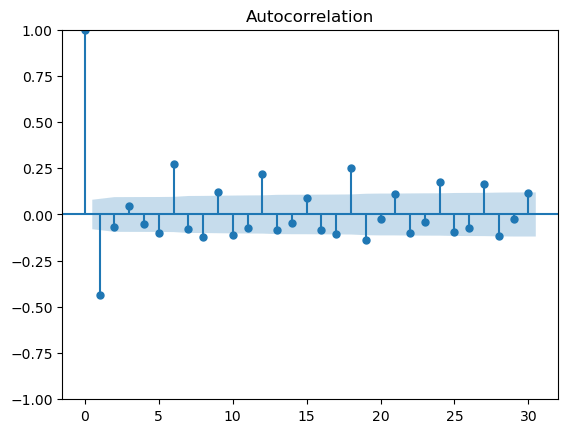

In [17]:
transformed_df = pd.DataFrame()
transformed_df["Sales"] = pd.Series(daily_sales["Sales"]).diff().dropna()
time_series = transformed_df["Sales"]
plot_acf(time_series, lags=30)
plt.show()

In [18]:
best_window_size = 6

# Initialize variables for MAPE calculation on test set
dynamic_forecasts = []
rolling_window = y_train[-best_window_size:].tolist()
total_absolute_percentage_error = 0

# Make dynamic forecasts on the test set
for actual in y_test:
    current_forecast = sum(rolling_window) / best_window_size
    dynamic_forecasts.append(current_forecast)

    # Calculate absolute percentage error
    absolute_percentage_error = abs((actual - current_forecast) / actual)
    total_absolute_percentage_error += absolute_percentage_error

    # Update the rolling window
    rolling_window.pop(0)
    rolling_window.append(actual)

# Calculate MAPE on the test set
mape_test = (total_absolute_percentage_error / len(y_test))

print("Test MAPE (MA):", mape_test)

Test MAPE (MA): 0.4459434140707443


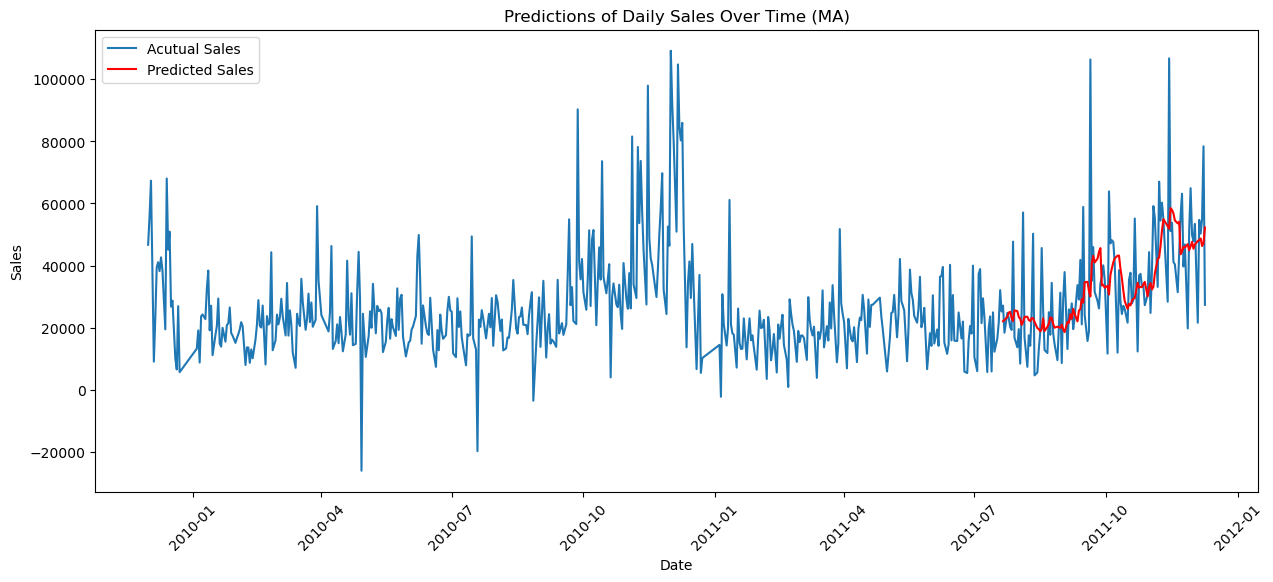

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], dynamic_forecasts, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (MA)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [20]:
period_size = len(y_test) // 4

# Initialize a list to store MAPE values for each period
mape_periods = []

# Iterate over the test set, dividing it into four equal periods
for i in range(4):
    # Define the start and end indices for the current period
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)

    # Extract the actual values for the current period
    actual_values = y_test[start_index:end_index]

    # Initialize variables for MAPE calculation on the current period
    dynamic_forecasts = []
    rolling_window = y_train[-best_window_size:].tolist()
    total_absolute_percentage_error = 0

    # Make dynamic forecasts on the current period
    for actual in actual_values:
        # Calculate the current forecast using the moving average
        current_forecast = sum(rolling_window) / best_window_size
        dynamic_forecasts.append(current_forecast)

        # Calculate absolute percentage error
        absolute_percentage_error = abs((actual - current_forecast) / actual)
        total_absolute_percentage_error += absolute_percentage_error

        # Update the rolling window
        rolling_window.pop(0)
        rolling_window.append(actual)

    mape_period = (total_absolute_percentage_error / len(actual_values))

    mape_periods.append(mape_period)

    print(f"MAPE for Period {i + 1}: {mape_period}")

# Calculate the average MAPE across all periods
average_mape = np.mean(mape_periods)
print("Average MAPE:", average_mape)

MAPE for Period 1: 0.6382483629946152
MAPE for Period 2: 0.44096245002327633
MAPE for Period 3: 0.38381499915619616
MAPE for Period 4: 0.3534532361733205
Average MAPE: 0.454119762086852


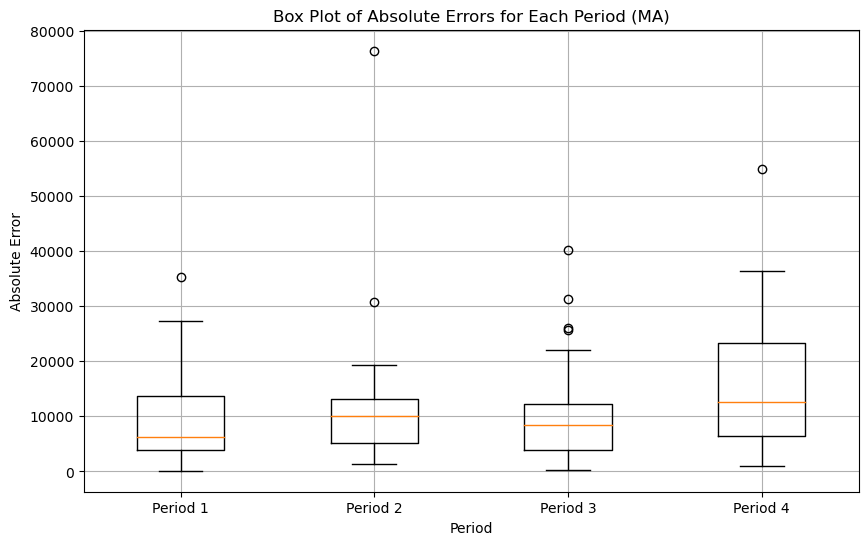

In [21]:
absolute_errors_periods = []

for i in range(4):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    actual_values = y_test[start_index:end_index]
    dynamic_forecasts = []
    rolling_window = y_train[-best_window_size:].tolist()
    absolute_errors = []

    for actual in actual_values:
        current_forecast = sum(rolling_window) / best_window_size
        absolute_error = abs(actual - current_forecast)
        absolute_errors.append(absolute_error)
        rolling_window.pop(0)
        rolling_window.append(actual)

    absolute_errors_periods.append(absolute_errors)

plt.figure(figsize=(10, 6))
plt.boxplot(absolute_errors_periods, labels=[f"Period {i+1}" for i in range(4)])
plt.title("Box Plot of Absolute Errors for Each Period (MA)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

### AR

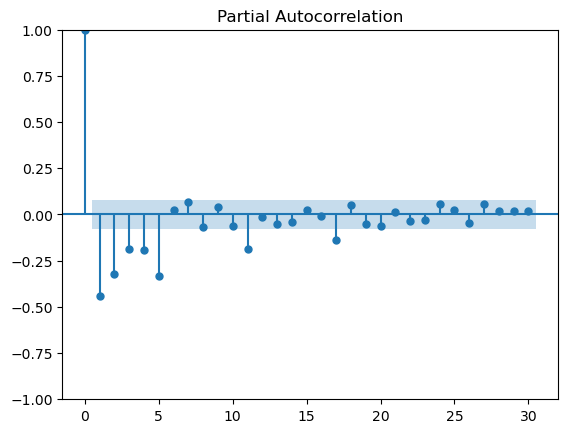

In [22]:
transformed_df = pd.DataFrame()
transformed_df["Sales"] = pd.Series(daily_sales["Sales"]).diff().dropna()
time_series = transformed_df["Sales"]
plot_pacf(time_series, lags=30) 
plt.show()

In [23]:
ar_model = AutoReg(y_train, lags=5).fit()
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Sales   No. Observations:                  483
Model:                     AutoReg(5)   Log Likelihood               -5192.686
Method:               Conditional MLE   S.D. of innovations          12637.462
Date:                Fri, 22 Mar 2024   AIC                          10399.372
Time:                        19:31:54   BIC                          10428.559
Sample:                             5   HQIC                         10410.846
                                  483                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6101.3917   1383.257      4.411      0.000    3390.258    8812.526
Sales.L1       0.3121      0.045      6.944      0.000       0.224       0.400
Sales.L2       0.0994      0.047      2.108      0.0

In [25]:
pred_ar = ar_model.predict(start=len(y_train), end=(len(y_train) + len(y_test) - 1), dynamic=True)

absolute_percentage_errors = abs((y_test - pred_ar) / y_test)

mape = absolute_percentage_errors.mean()

print("Test MAPE (AR):", mape)

Test MAPE (AR): 0.4966011355970002


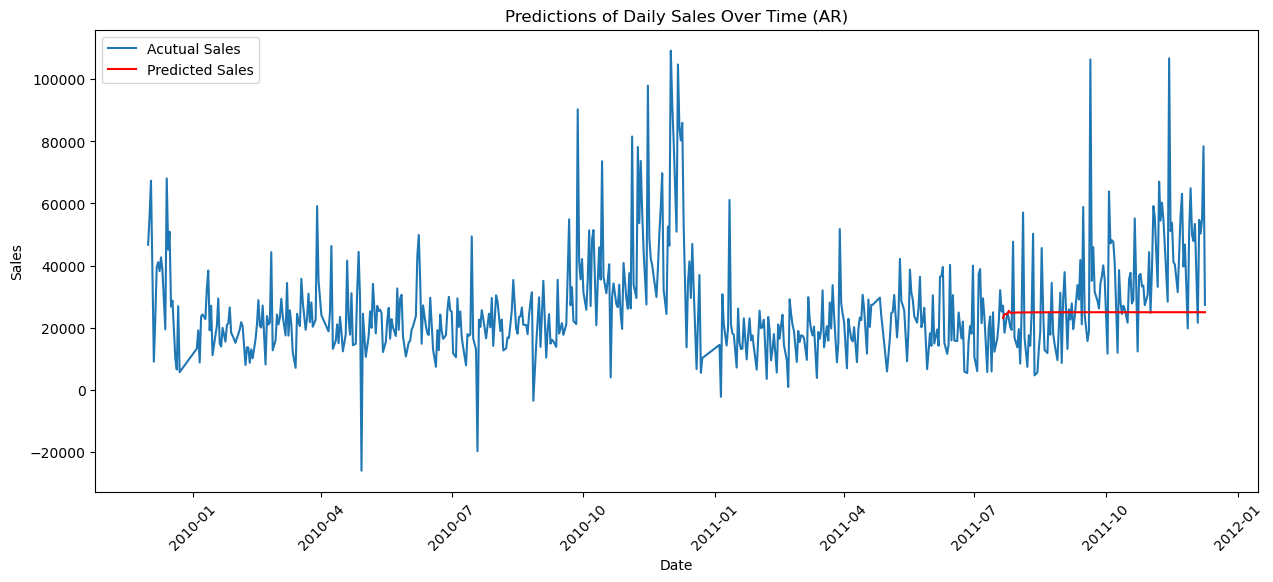

In [26]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], pred_ar, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (AR)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [27]:
period_size = len(y_test) // 4
absolute_errors_periods_ar = []

for i in range(4):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    actual_values = y_test[start_index:end_index]
    pred_values = pred_ar[start_index:end_index]
    absolute_errors_ar = abs(actual_values - pred_values)
    absolute_errors_periods_ar.append(absolute_errors_ar)
    mape_period = mean_absolute_percentage_error(actual_values, pred_values)
    print(f"MAPE for Period {i+1}: {mape_period}")

MAPE for Period 1: 0.754534043011996
MAPE for Period 2: 0.40492121989328866
MAPE for Period 3: 0.3659183431234688
MAPE for Period 4: 0.46217836214111113


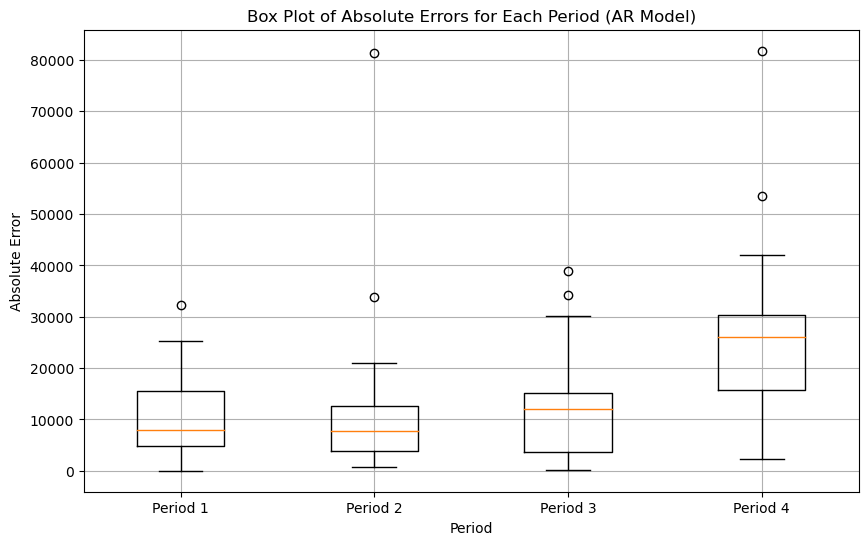

In [28]:
plt.figure(figsize=(10, 6))
boxplot_ar = plt.boxplot(absolute_errors_periods_ar, labels=[f"Period {i+1}" for i in range(4)])

plt.title("Box Plot of Absolute Errors for Each Period (AR Model)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

### ARIMA

In [29]:
arima_model = auto_arima(y_train, start_p=1, start_q=1,
                      max_p=10, max_q=10,d=1,
                      seasonal=False,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10500.787, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10682.913, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10599.806, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10504.488, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10680.918, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10502.011, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=10500.420, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=10498.909, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=10500.830, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=10502.253, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=10496.876, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10502.228, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=10498.448, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=10498.583, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0

In [30]:
ARIMA_model = ARIMA(endog= y_train, order=(0, 1, 2)).fit()
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  483
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -5245.438
Date:                Fri, 22 Mar 2024   AIC                          10496.876
Time:                        19:32:32   BIC                          10509.410
Sample:                             0   HQIC                         10501.802
                                - 483                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6776      0.040    -16.909      0.000      -0.756      -0.599
ma.L2         -0.1285      0.034     -3.807      0.000      -0.195      -0.062
sigma2      1.611e+08   9.01e-12   1.79e+19      0.0

In [31]:
pred_arima = ARIMA_model.predict(start=len(y_train), end=(len(daily_sales)-1))
test_mape_arima = mean_absolute_percentage_error(y_test, pred_arima)
print(f"Test MAPE (ARIMA): {test_mape_arima}")

Test MAPE (ARIMA): 0.4863525095781793


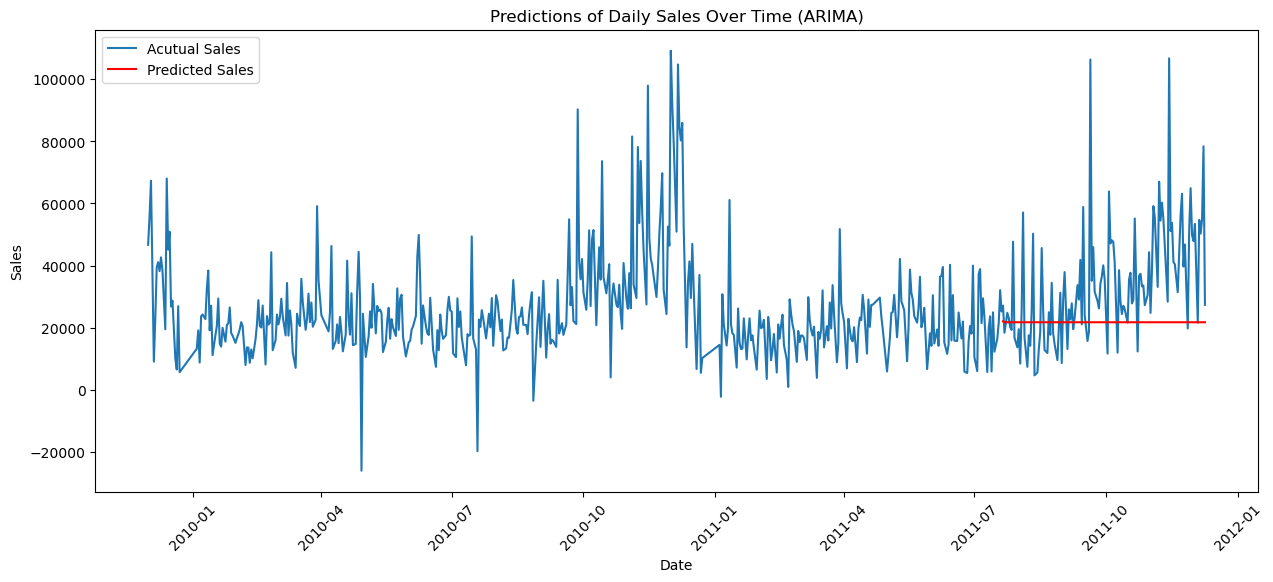

In [32]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], pred_arima, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [33]:
period_size = len(y_test) // 4
absolute_errors_periods_arima = []

for i in range(4):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    actual_values = y_test[start_index:end_index]
    pred_values = pred_arima[start_index:end_index]
    absolute_errors_arima = abs(actual_values - pred_values)
    absolute_errors_periods_arima.append(absolute_errors_arima)
    mape_period = mean_absolute_percentage_error(actual_values, pred_values)
    print(f"MAPE for Period {i+1}: {mape_period}")

MAPE for Period 1: 0.6258678188691641
MAPE for Period 2: 0.3918600745824984
MAPE for Period 3: 0.4116074586150643
MAPE for Period 4: 0.5151159063534805


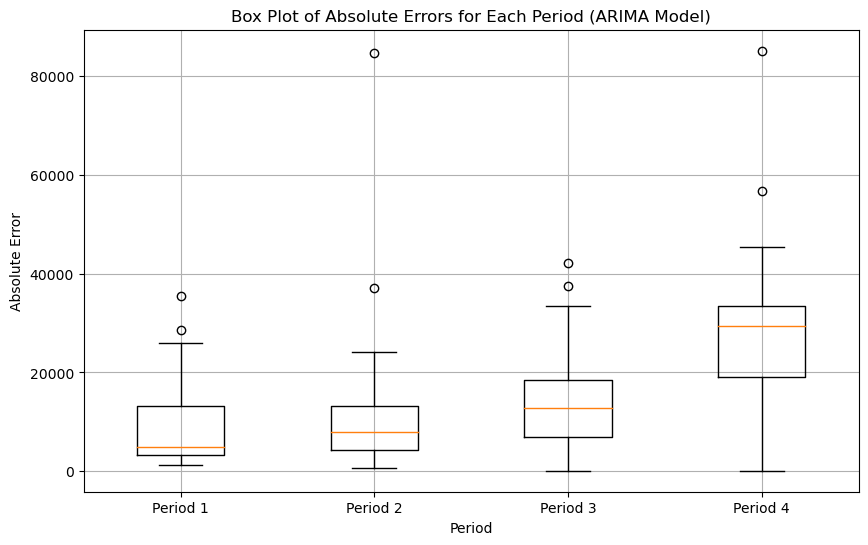

In [34]:
plt.figure(figsize=(10, 6))
boxplot_arima = plt.boxplot(absolute_errors_periods_arima, labels=[f"Period {i+1}" for i in range(4)])

plt.title("Box Plot of Absolute Errors for Each Period (ARIMA Model)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

### SARIMA

In [35]:
sarima_model = auto_arima(y_train,start_p=1,start_q=1,test='adf',m=6,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[6] intercept   : AIC=10506.649, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[6] intercept   : AIC=10705.616, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[6] intercept   : AIC=10523.679, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[6] intercept   : AIC=10578.319, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[6]             : AIC=11323.423, Time=0.01 sec
 ARIMA(1,0,1)(0,0,1)[6] intercept   : AIC=10507.249, Time=0.07 sec
 ARIMA(1,0,1)(1,0,0)[6] intercept   : AIC=10504.682, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[6] intercept   : AIC=10544.549, Time=0.04 sec
 ARIMA(1,0,1)(2,0,0)[6] intercept   : AIC=10498.251, Time=0.26 sec
 ARIMA(1,0,1)(2,0,1)[6] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,1)(2,0,0)[6] intercept   : AIC=10597.956, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[6] intercept   : AIC=10520.389, Time=0.13 sec
 ARIMA(2,0,1)(2,0,0)[6] intercept   : AIC=10490.038, Time=0.33 sec
 ARIMA(2,0,1)(1,0,0)[6] intercept   : AIC=10497.191, Time=0.13 sec
 ARIMA(2,0,1)(2,0,1)[6] i

In [36]:
SARIMA_model = SARIMAX(y_train, order=(5,0,2), seasonal_order=(1,0,1,6)).fit()
print(SARIMA_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10243D+01    |proj g|=  5.86459D-01

At iterate    5    f=  1.08514D+01    |proj g|=  7.79091D-02

At iterate   10    f=  1.08428D+01    |proj g|=  1.46282D-02


 This problem is unconstrained.



At iterate   15    f=  1.08381D+01    |proj g|=  1.69383D-02

At iterate   20    f=  1.08374D+01    |proj g|=  1.24980D-03

At iterate   25    f=  1.08370D+01    |proj g|=  4.40570D-03

At iterate   30    f=  1.08360D+01    |proj g|=  5.59402D-03

At iterate   35    f=  1.08344D+01    |proj g|=  1.62676D-03

At iterate   40    f=  1.08342D+01    |proj g|=  2.12093D-03

At iterate   45    f=  1.08321D+01    |proj g|=  2.51252D-02

At iterate   50    f=  1.08310D+01    |proj g|=  1.97244D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     57      1     0     0   1.972D-02   1.083D+01
  F =   10.8309517301

In [37]:
pred_sarima = SARIMA_model.predict(start=len(y_train), end=(len(daily_sales)-1))
test_mape_sarima = mean_absolute_percentage_error(y_test, pred_sarima)
print(f"Test MAPE (SARIMA): {test_mape_sarima}")

Test MAPE (SARIMA): 0.5571039131066874


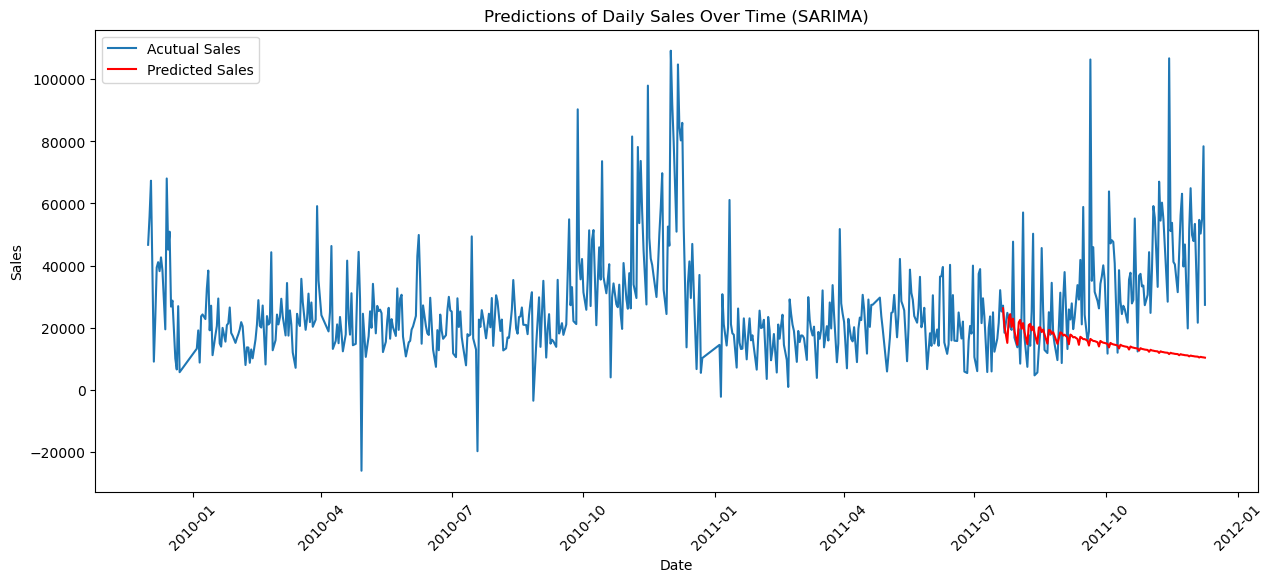

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], pred_sarima, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [39]:
absolute_errors_periods_sarima = []

for i in range(4):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    actual_values = y_test[start_index:end_index]
    pred_values = pred_sarima[start_index:end_index]
    absolute_errors_sarima = abs(actual_values - pred_values)
    absolute_errors_periods_sarima.append(absolute_errors_sarima)
    mape_period = mean_absolute_percentage_error(actual_values, pred_values)
    print(f"MAPE for Period {i+1}: {mape_period}")

MAPE for Period 1: 0.4746844973079904
MAPE for Period 2: 0.44183867833688134
MAPE for Period 3: 0.5612590476931005
MAPE for Period 4: 0.7443905414764523


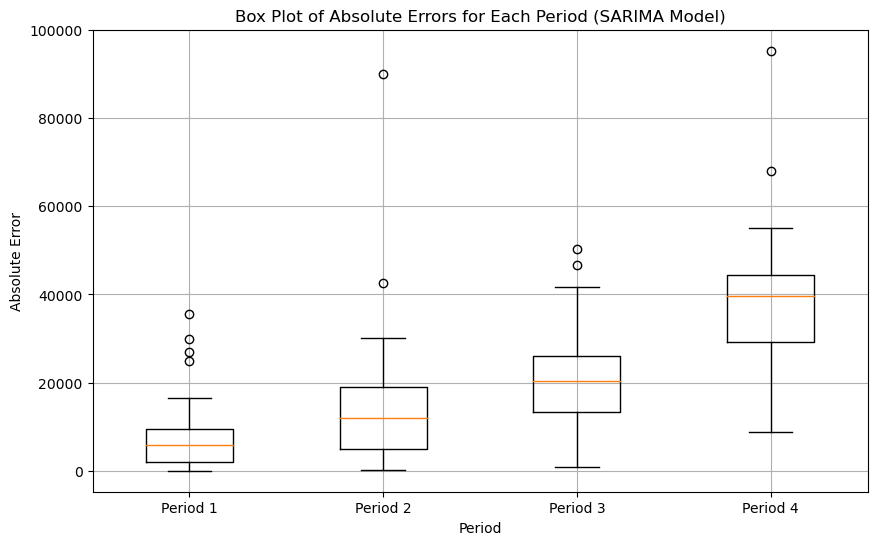

In [40]:
plt.figure(figsize=(10, 6))
boxplot_sarima = plt.boxplot(absolute_errors_periods_sarima, labels=[f"Period {i+1}" for i in range(4)])

plt.title("Box Plot of Absolute Errors for Each Period (SARIMA Model)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

### Facebook Prophet

In [41]:
X_fp = daily_sales.drop(['Sales'], axis=1)
y_fp = daily_sales['Sales']
X_train_fp, X_test_fp, y_train_fp, y_test_fp = train_test_split(X_fp, y_fp, test_size=0.2, shuffle=False)

19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing
19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing
19:33:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing
19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing
19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:04 - cmdstanpy - INFO - Chain [1] done processing
19:33:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:04 - cmdstanpy - INFO - Chain [1] start processing
19:33:05 - cmdstanpy - INFO - Chain [1] done processing
19:33:05 - cmdstanpy - INFO - Chain [1] start processing
19:33:05 - cmdstanpy - INFO - Chain [1] done processing
19:33:05 -

  0%|          | 0/7 [00:00<?, ?it/s]

19:33:05 - cmdstanpy - INFO - Chain [1] start processing
19:33:05 - cmdstanpy - INFO - Chain [1] done processing
19:33:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:05 - cmdstanpy - INFO - Chain [1] start processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing
19:33:06 - cmdstanpy - INFO - Chain [1] start processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing
19:33:06 - cmdstanpy - INFO - Chain [1] start processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing
19:33:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:06 - cmdstanpy - INFO - Chain [1] start processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing
19:33:06 - cmdstanpy - INFO - Chain [1] start processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing
19:33:06 -

  0%|          | 0/7 [00:00<?, ?it/s]

19:33:06 - cmdstanpy - INFO - Chain [1] start processing
19:33:06 - cmdstanpy - INFO - Chain [1] done processing
19:33:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:07 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing
19:33:07 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing
19:33:07 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing
19:33:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:07 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing
19:33:07 - cmdstanpy - INFO - Chain [1] start processing
19:33:07 - cmdstanpy - INFO - Chain [1] done processing
19:33:07 -

  0%|          | 0/7 [00:00<?, ?it/s]

19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing
19:33:09 -

  0%|          | 0/7 [00:00<?, ?it/s]

19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing
19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing
19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing
19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing
19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing
19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing
19:33:09 - cmdstanpy - INFO - Chain [1] start processing
19:33:09 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:10 - cmdstanpy - INFO - Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:11 - cmdstanpy - INFO - Chain [1] start processing
19:33:11 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:12 - cmdstanpy - INFO - Chain [1] start processing
19:33:12 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
19:33:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:15 - cmdstanpy - INFO - Chain [1] done processing
19:33:15 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:16 - cmdstanpy - INFO - Chain [1] start processing
19:33:16 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:17 - cmdstanpy - INFO - Chain [1] start processing
19:33:17 - cmdstanpy - INFO - Chain [1] done processing
19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/7 [00:00<?, ?it/s]

19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:18 - cmdstanpy - INFO - Chain [1] start processing
19:33:18 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing


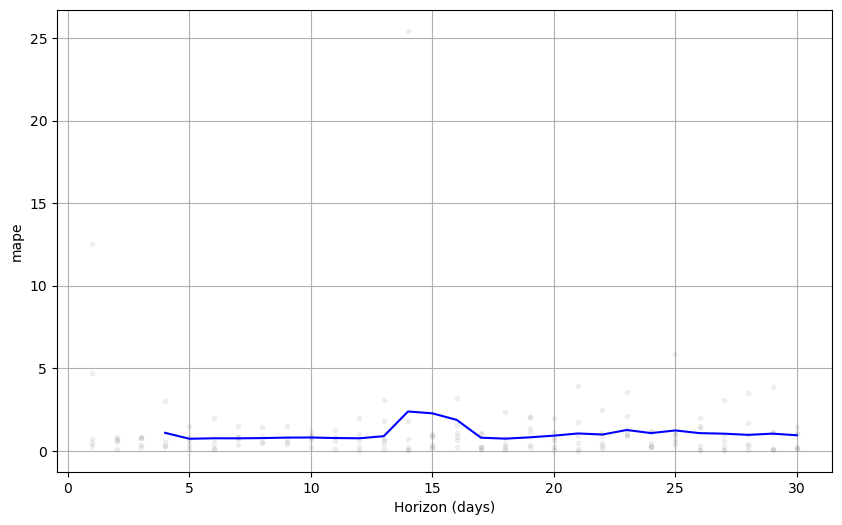

In [42]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

train_data = pd.concat([X_train_fp, y_train_fp], axis=1)
train_data.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)

model = Prophet()
model.fit(train_data)

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

cv_results = []

for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        tuned_model = Prophet(changepoint_prior_scale=changepoint_prior_scale,
                              seasonality_prior_scale=seasonality_prior_scale).fit(train_data)
        df_cv = cross_validation(tuned_model, initial='365 days', period='30 days', horizon='30 days')
        df_metrics = performance_metrics(df_cv, rolling_window=1)
        mape = df_metrics['mape'].mean()
        cv_results.append({
            'changepoint_prior_scale': changepoint_prior_scale,
            'seasonality_prior_scale': seasonality_prior_scale,
            'mape': mape
        })

cv_results_df = pd.DataFrame(cv_results)

fig = plot_cross_validation_metric(df_cv, metric='mape')


In [43]:
best_params_row = cv_results_df.loc[cv_results_df['mape'].idxmin()]

best_changepoint_prior_scale = best_params_row['changepoint_prior_scale']
best_seasonality_prior_scale = best_params_row['seasonality_prior_scale']
best_mape = best_params_row['mape']

print("Best hyperparameters:")
print(f"Changepoint Prior Scale: {best_changepoint_prior_scale}")
print(f"Seasonality Prior Scale: {best_seasonality_prior_scale}")
print(f"MAPE: {best_mape}")

Best hyperparameters:
Changepoint Prior Scale: 0.001
Seasonality Prior Scale: 10.0
MAPE: 0.8714432518022334


In [44]:
fb_model = Prophet(changepoint_prior_scale=best_changepoint_prior_scale,
                      seasonality_prior_scale=best_seasonality_prior_scale)
fb_model.fit(train_data)

future = fb_model.make_future_dataframe(periods=len(X_test_fp))
forecast = fb_model.predict(future)

actual_values = y_test_fp.values
predicted_values = forecast[-len(X_test_fp):]['yhat'].values

mape = np.mean(np.abs((actual_values - predicted_values) / actual_values))
print("Test MAPE (Facebook Prophet):", mape)

19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing


Test MAPE (Facebook Prophet): 0.6294145200738901


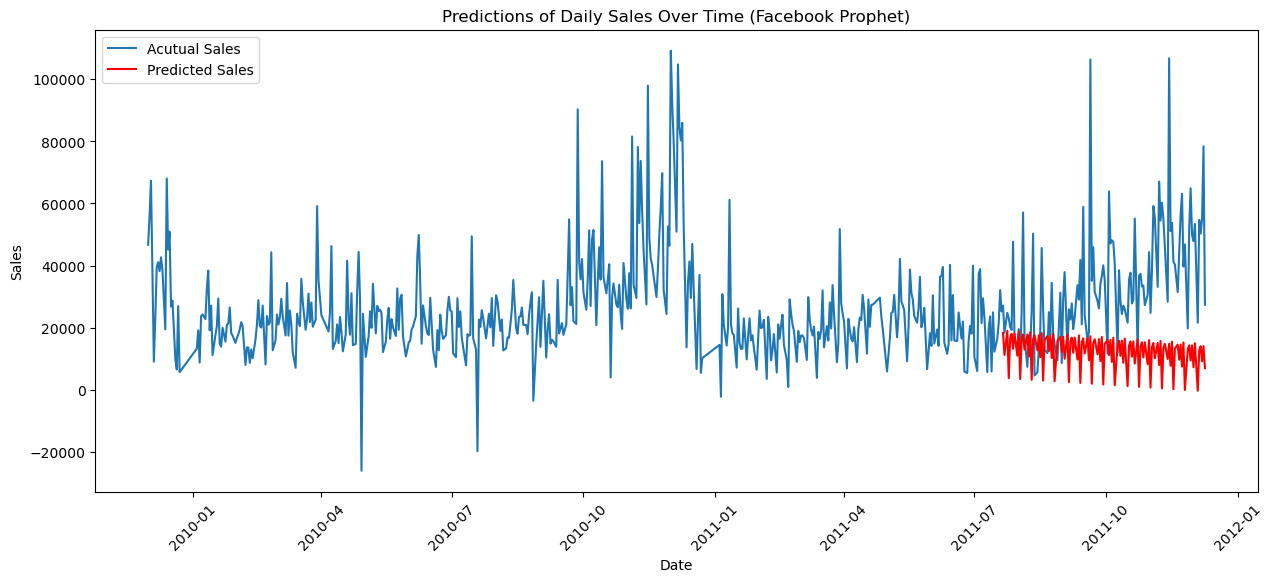

In [45]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], predicted_values, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (Facebook Prophet)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [47]:
period_length = len(X_test_fp) // 4
test_periods = [y_test_fp[i:i+period_length] for i in range(0, len(y_test_fp), period_length)]
mape_periods = []
predictions_periods = []
absolute_errors_periods_prophet = []

# Calculate MAPE for each period and collect predictions
for i, period in enumerate(test_periods[:4]):  # Limiting to 4 periods
    future = fb_model.make_future_dataframe(periods=len(period))
    forecast = fb_model.predict(future)
    actual_values = period.values
    predicted_values = forecast[-len(period):]['yhat'].values
    absolute_errors = np.abs(actual_values - predicted_values)
    absolute_errors_periods_prophet.append(absolute_errors)
    mape_period = np.mean(np.abs((actual_values - predicted_values) / actual_values))
    mape_periods.append(mape_period)
    predictions_periods.append(predicted_values)
    print(f"MAPE for Period {i+1}: {mape_period}")

MAPE for Period 1: 0.5628485478755899
MAPE for Period 2: 0.5268424590284371
MAPE for Period 3: 0.5794433392939137
MAPE for Period 4: 0.6851553009052231


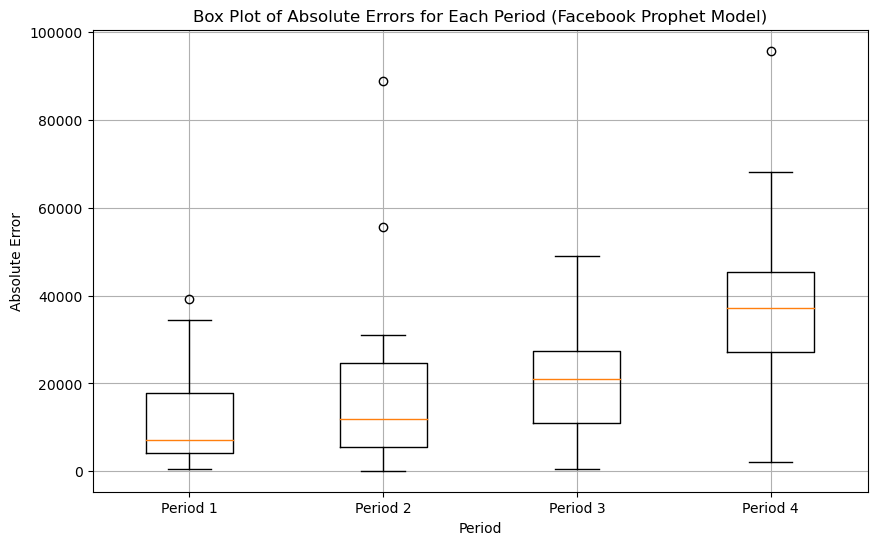

In [48]:
# Plot box plot of absolute errors for each period
plt.figure(figsize=(10, 6))
boxplot_prophet = plt.boxplot(absolute_errors_periods_prophet, labels=[f"Period {i+1}" for i in range(len(absolute_errors_periods_prophet))])

plt.title("Box Plot of Absolute Errors for Each Period (Facebook Prophet Model)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

## Part 5：Machine Learning Models

Elastic-Net Regularization, Random Forest, SVR, XGBoost

### Elastic-Net Regularization

Some of the ML models can't have nan values, so we are filling in nan values.

In [49]:
X_train['Sales_ma_3'] = X_train['Sales_ma_3'].fillna(X_train['Sales_ma_3'].mean())
X_train['Sales_ma_7'] = X_train['Sales_ma_7'].fillna(X_train['Sales_ma_7'].mean())
X_train['Sales_ma_15'] = X_train['Sales_ma_15'].fillna(X_train['Sales_ma_15'].mean())
X_train['Sales_ma_30'] = X_train['Sales_ma_30'].fillna(X_train['Sales_ma_30'].mean())
X_train['snow_depth'] = X_train['snow_depth'].fillna(0)

In [50]:
X_test['Sales_ma_3'] = X_test['Sales_ma_3'].fillna(X_train['Sales_ma_3'].mean())
X_test['Sales_ma_7'] = X_test['Sales_ma_7'].fillna(X_train['Sales_ma_7'].mean())
X_test['Sales_ma_15'] = X_test['Sales_ma_15'].fillna(X_train['Sales_ma_15'].mean())
X_test['Sales_ma_30'] = X_test['Sales_ma_30'].fillna(X_train['Sales_ma_30'].mean())
X_test['snow_depth'] = X_test['snow_depth'].fillna(0)

In [51]:
# Define the parameter grid for Elastic Net
en_grid = {
    'alpha': [0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Prepare the cross-validation method
tscv = TimeSeriesSplit(n_splits=5)
mape_scorer = make_scorer(mean_absolute_percentage_error)

# Elastic Net grid search
elastic_net = ElasticNet()
en_grid_search = GridSearchCV(estimator=elastic_net, param_grid=en_grid, cv=tscv, scoring=mape_scorer, verbose=1)
en_grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_en_params = en_grid_search.best_params_
print(f"Best Elastic Net Hyperparameters: {best_en_params}")

# Evaluate the best Elastic Net model on the test set
best_en_model = ElasticNet(**best_en_params)
best_en_model.fit(X_train, y_train)
y_test_pred_en = best_en_model.predict(X_test)
test_mape_en = mean_absolute_percentage_error(y_test, y_test_pred_en)
print(f"Test MAPE (Elastic Net): {test_mape_en}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Elastic Net Hyperparameters: {'alpha': 0.1, 'l1_ratio': 0.9}
Test MAPE (Elastic Net): 0.33492083095902014


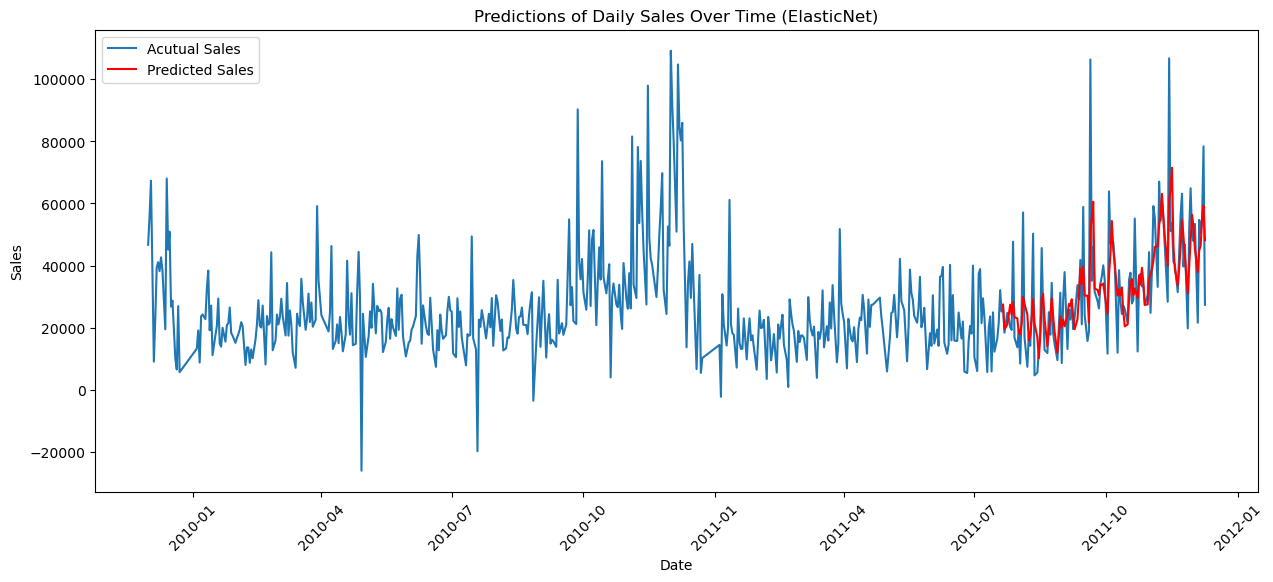

In [52]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], y_test_pred_en, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (ElasticNet)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [53]:
period_length = len(X_test) // 4

# Split the test set into 4 equal periods
test_periods = [y_test[i:i + period_length] for i in range(0, len(y_test), period_length)]

# Initialize lists to store absolute errors for each period
absolute_errors_periods = []

# Iterate over each period and calculate absolute errors
for period in test_periods:
    # Make predictions for the current period
    y_pred_period = best_en_model.predict(X_test[:len(period)])
    # Calculate absolute errors for the current period
    absolute_errors = np.abs(y_pred_period - period)
    # Append absolute errors to the list
    absolute_errors_periods.append(absolute_errors)

mape_periods = []

# Iterate over the first three periods and calculate MAPE
for i, period in enumerate(test_periods[:-1]):
    # Make predictions for the current period
    y_pred_period = best_en_model.predict(X_test[:len(period)])
    # Calculate absolute errors for the current period
    absolute_errors = np.abs(y_pred_period - period)
    # Calculate MAPE for the current period
    mape_period = np.mean(np.abs(absolute_errors / period))
    # Append MAPE to the list
    mape_periods.append(mape_period)
    # Print MAPE for the current period
    print(f"MAPE for Period {i+1}: {mape_period}")

MAPE for Period 1: 0.5409676487608956
MAPE for Period 2: 0.4216055804430061
MAPE for Period 3: 0.42357549094967556
MAPE for Period 4: 0.5059920480797866


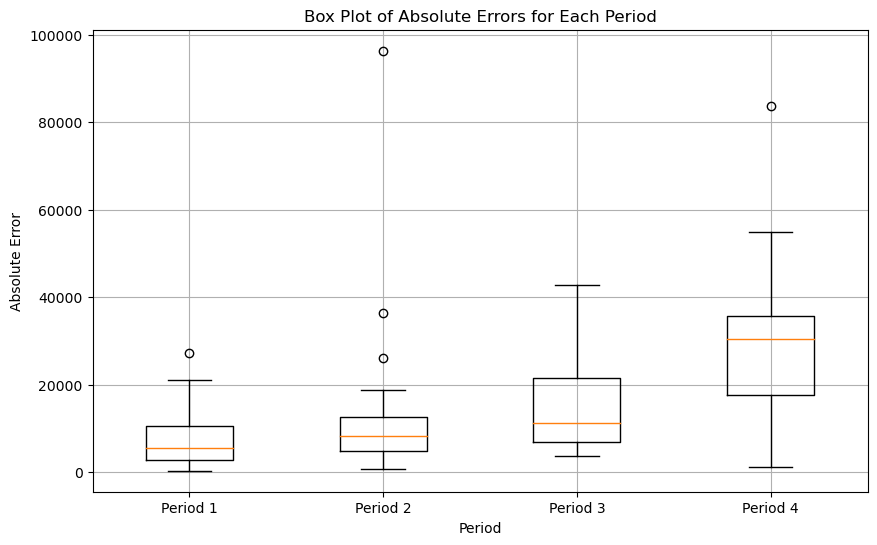

In [54]:
absolute_errors_periods = []

# Iterate over the first three periods and calculate absolute errors
for i, period in enumerate(test_periods[:-1]):
    # Make predictions for the current period
    y_pred_period = best_en_model.predict(X_test[:len(period)])
    # Calculate absolute errors for the current period
    absolute_errors = np.abs(y_pred_period - period)
    # Append absolute errors to the list
    absolute_errors_periods.append(absolute_errors)

# Plot box plots for each period's absolute errors
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(absolute_errors_periods, labels=[f"Period {i+1}" for i in range(len(absolute_errors_periods))])
plt.title("Box Plot of Absolute Errors for Each Period")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

### Random Forest

In [55]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# For the random forest regressor
rf_grid = {
    "n_estimators": [10, 50, 100, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10]
}

# Prepare cross-validation and scoring method
tscv = TimeSeriesSplit(n_splits=5)
mape_scorer = make_scorer(mean_absolute_percentage_error)

# Random Forest grid search
rf = RandomForestRegressor()
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_grid, cv=tscv, scoring=mape_scorer, verbose=1)
rf_grid_search.fit(X_train, y_train)
best_rf_params = rf_grid_search.best_params_
print(f"Best Random Forest Hyperparameters: {best_rf_params}")

# Random Forest
best_rf = RandomForestRegressor(**best_rf_params)
best_rf.fit(X_train, y_train)
y_test_pred_rf = best_rf.predict(X_test)
test_mape_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf)
print(f"Test MAPE (Random Forest): {test_mape_rf}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 10}
Test MAPE (Random Forest): 0.3322289197014001


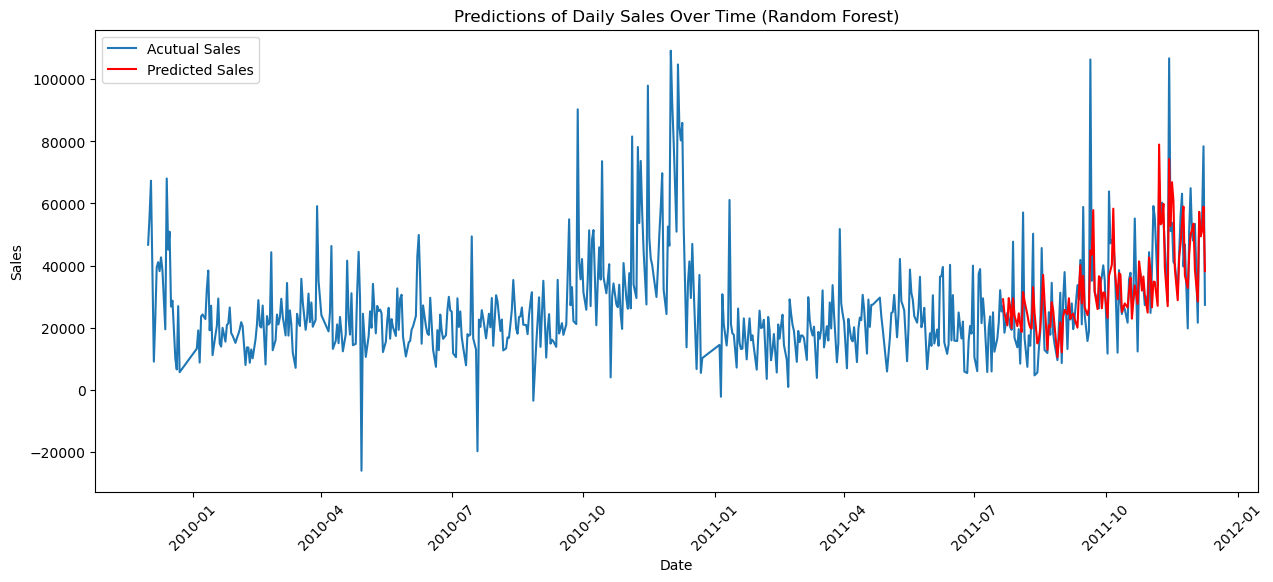

In [56]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], y_test_pred_rf, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [57]:
period_size = len(y_test) // 4
absolute_errors_periods_rf = []

for i in range(4):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    X_test_period = X_test[start_index:end_index]
    y_test_period = y_test[start_index:end_index]
    y_pred_period_rf = best_rf.predict(X_test_period)
    absolute_errors_rf = abs(y_test_period - y_pred_period_rf)
    absolute_errors_periods_rf.append(absolute_errors_rf)
    mape_period_rf = mean_absolute_percentage_error(y_test_period, y_pred_period_rf)
    print(f"MAPE for Period {i+1}: {mape_period_rf}")


MAPE for Period 1: 0.6072896065367952
MAPE for Period 2: 0.26402459539065937
MAPE for Period 3: 0.2705446765728612
MAPE for Period 4: 0.1917397718987078


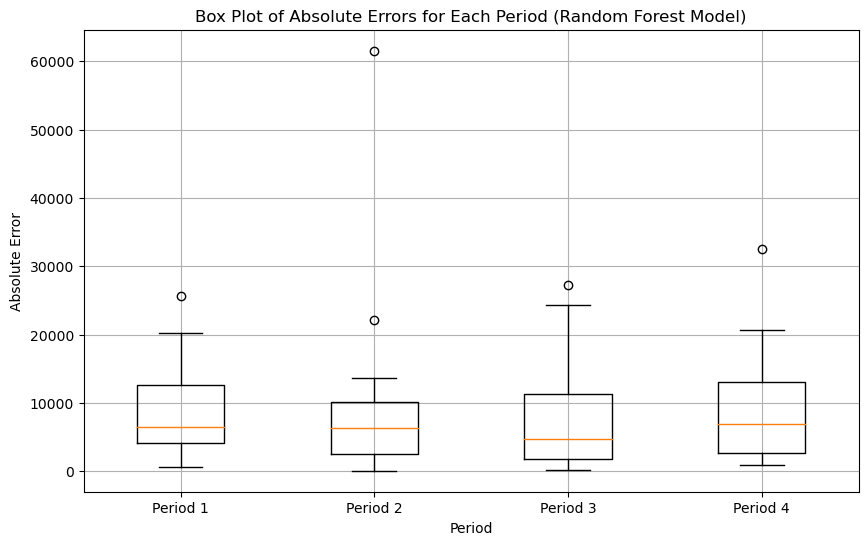

In [58]:
plt.figure(figsize=(10, 6))
boxplot_rf = plt.boxplot(absolute_errors_periods_rf, labels=[f"Period {i+1}" for i in range(4)])

plt.title("Box Plot of Absolute Errors for Each Period (Random Forest Model)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

### SVR

In [59]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tscv = TimeSeriesSplit(n_splits=5)

param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100, 1000, 10000],
    'epsilon': [0.01, 0.1, 0.5, 1],
    'gamma': [0.01, 0.1, 0.5]
}

grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=tscv, scoring=mape_scorer, verbose=1)
grid_search.fit(X_scaled, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred_test_svr = best_model.predict(X_test_scaled)
test_mape_svr = mean_absolute_percentage_error(y_test, y_pred_test_svr)
print(f"Test MAPE: {test_mape_svr}")

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best Hyperparameters: {'C': 10000, 'epsilon': 0.01, 'gamma': 0.5}
Test MAPE: 0.39006285299826465


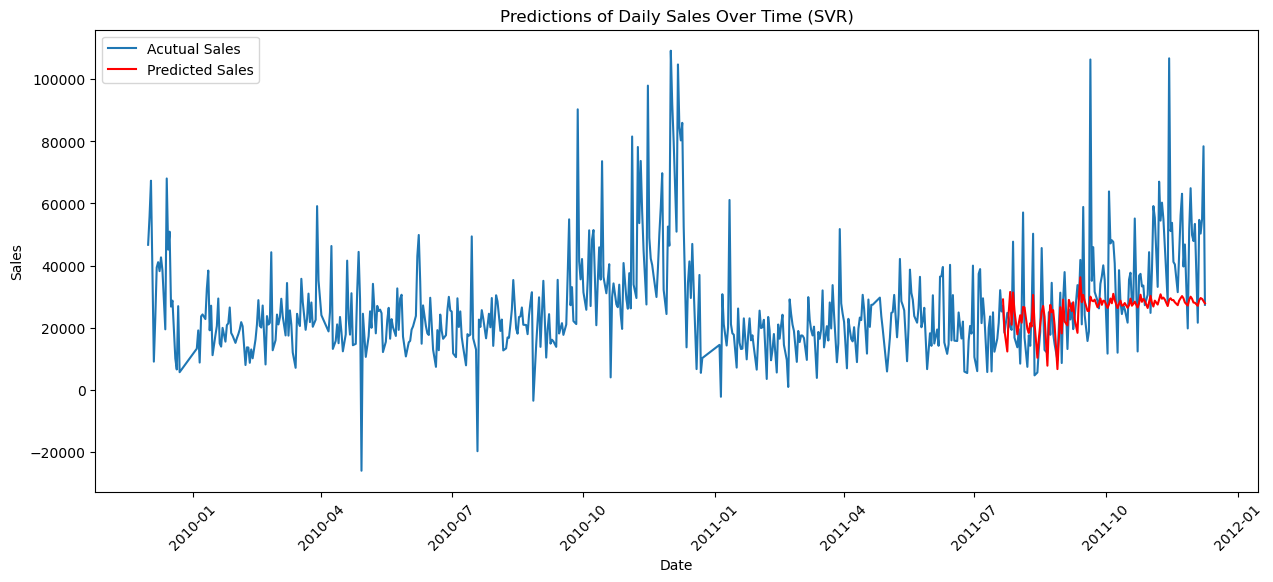

In [60]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], y_pred_test_svr, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (SVR)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [61]:
period_size = len(y_test) // 4
absolute_errors_periods_svr = []

for i in range(4):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    X_test_period = X_test[start_index:end_index]
    y_test_period = y_test[start_index:end_index]
    y_pred_period_svr = best_model.predict(X_test_period)
    absolute_errors_svr = abs(y_test_period - y_pred_period_svr)
    absolute_errors_periods_svr.append(absolute_errors_rf)
    mape_period_svr = mean_absolute_percentage_error(y_test_period, y_pred_period_svr)
    print(f"MAPE for Period {i+1}: {mape_period_svr}")

MAPE for Period 1: 0.8476116940660564
MAPE for Period 2: 0.42329199386094435
MAPE for Period 3: 0.351272614095771
MAPE for Period 4: 0.4329996680492113


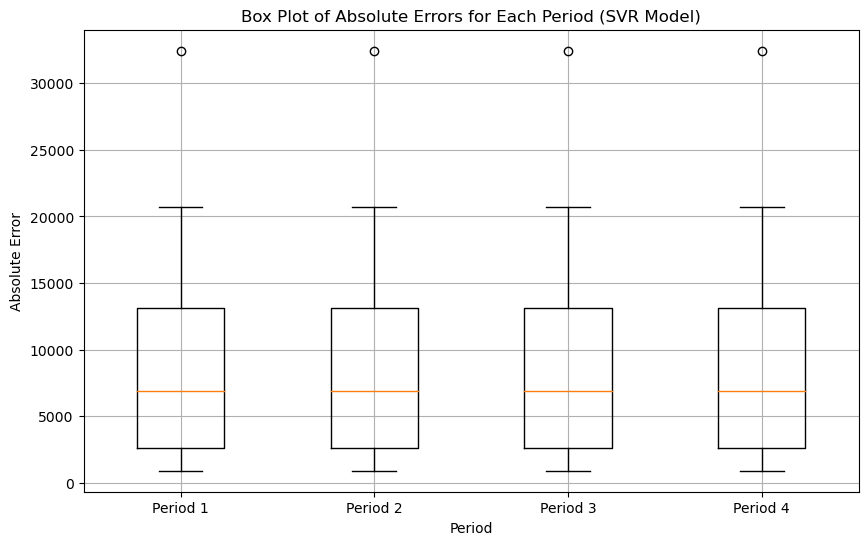

In [62]:
plt.figure(figsize=(10, 6))
boxplot_svr = plt.boxplot(absolute_errors_periods_svr, labels=[f"Period {i+1}" for i in range(4)])

plt.title("Box Plot of Absolute Errors for Each Period (SVR Model)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

### XGBoost

In [63]:
xgb_grid = {
    "max_depth": [2, 4, 6, 8],
    "n_estimators": [50, 100, 300, 500, 1000],
    "learning_rate": [0.02, 0.05, 0.1]
}

xgbr = xgb.XGBRegressor(eval_metric='mape')
tscv = TimeSeriesSplit(n_splits=5)
mape_scorer = make_scorer(mean_absolute_percentage_error)
grid_search = GridSearchCV(estimator=xgbr, param_grid=xgb_grid, cv=tscv, scoring=mape_scorer, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
final_model = xgb.XGBRegressor(**best_params, eval_metric='mape')
final_model.fit(X_train, y_train, verbose=True)
y_test_pred_xg = final_model.predict(X_test)
test_mape_xg = mean_absolute_percentage_error(y_test, y_test_pred_xg)
print(f"Test MAPE: {test_mape_xg}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Hyperparameters: {'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 50}
Test MAPE: 0.3700744514834794


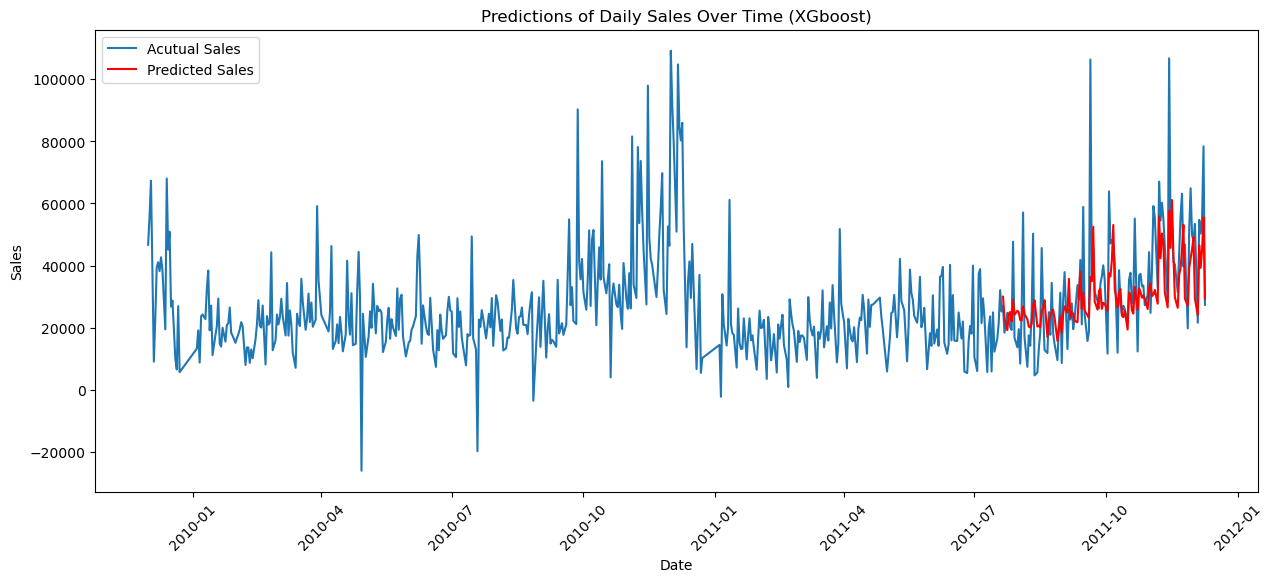

In [64]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], linestyle='-', label="Acutual Sales")
plt.plot(daily_sales['Date'][483:], y_test_pred_xg, color="red", label="Predicted Sales")
plt.title('Predictions of Daily Sales Over Time (XGboost)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [65]:
period_size = len(y_test) // 4
absolute_errors_periods_xgb = []

for i in range(4):
    start_index = i * period_size
    end_index = (i + 1) * period_size if i < 3 else len(y_test)
    X_test_period = X_test[start_index:end_index]
    y_test_period = y_test[start_index:end_index]
    y_pred_period_xgb = final_model.predict(X_test_period)
    absolute_errors_xgb = abs(y_test_period - y_pred_period_xgb)
    absolute_errors_periods_xgb.append(absolute_errors_xgb)
    mape_period_xgb = mean_absolute_percentage_error(y_test_period, y_pred_period_xgb)
    print(f"MAPE for Period {i+1}: {mape_period_xgb}")

MAPE for Period 1: 0.6829252707082385
MAPE for Period 2: 0.30216700595208734
MAPE for Period 3: 0.2795035895026833
MAPE for Period 4: 0.22068169821324957


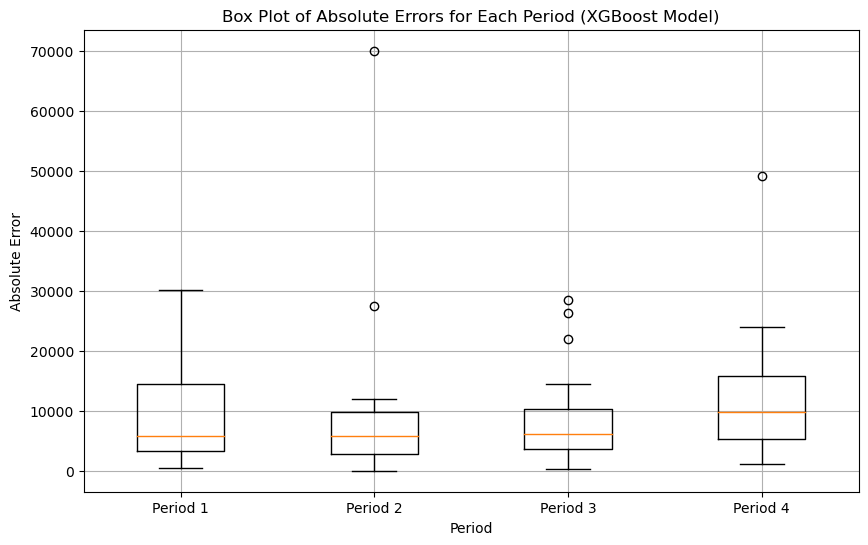

In [66]:
plt.figure(figsize=(10, 6))
boxplot_svr = plt.boxplot(absolute_errors_periods_xgb, labels=[f"Period {i+1}" for i in range(4)])

plt.title("Box Plot of Absolute Errors for Each Period (XGBoost Model)")
plt.xlabel("Period")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.show()

## Part 6: Results

| Model | Best Hyper-parameter         | Best Test MAPE |  Period 1 Test MAPE | Period 2 Test MAPE | Period 3 Test MAPE | Period 4 Test MAPE |
|----------|----------|----------|----------|----------|----------|----------|
| MA | {'q': 6} |  0.4459 | 0.6382 | 0.4410 | 0.3838 | 0.3535 |
| AR | {'p': 5} | 0.4986 | 0.7545 | 0.4049 | 0.3659 | 0.4622 |
| ARIMA | {'p':0, 'd':1, 'q':2} |0.4864 | 0.6259 | 0.3919 | 0.4116 | 0.5151 |
| SARIMA | {'p':5, 'd':0, 'q':2, 'P':1, 'D':0, 'Q':1}| 0.5571 | 0.4747 | 0.4418 | 0.5613 | 0.7444 |
| Facebook Prophet |{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10} | 0.6294 | 0.5628 | 0.5268 | 0.5794 | 0.6852 | 
| Elastic Net Regression | {'alpha': 0.1, 'l1_ratio': 0.9}  | 0.3349 | 0.5410 | 0.4216 | 0.4236 | 0.5060 | 
| Random Forest | {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}  | 0.3181 | 0.5647 | 0.2909 | 0.2496 | 0.1833 |
| SVR |{'C': 10000, 'epsilon': 0.01, 'gamma': 0.5}  | 0.3901 | 0.8476 | 0.4233 | 0.3513 | 0.4330 |
| XGBoost | {'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 50}  | 0.3701 | 0.6829 | 0.3022 | 0.2795 | 0.2207 |

Random Forest model appears to have the best test MAPE. Here is the feature important graph of random forest.

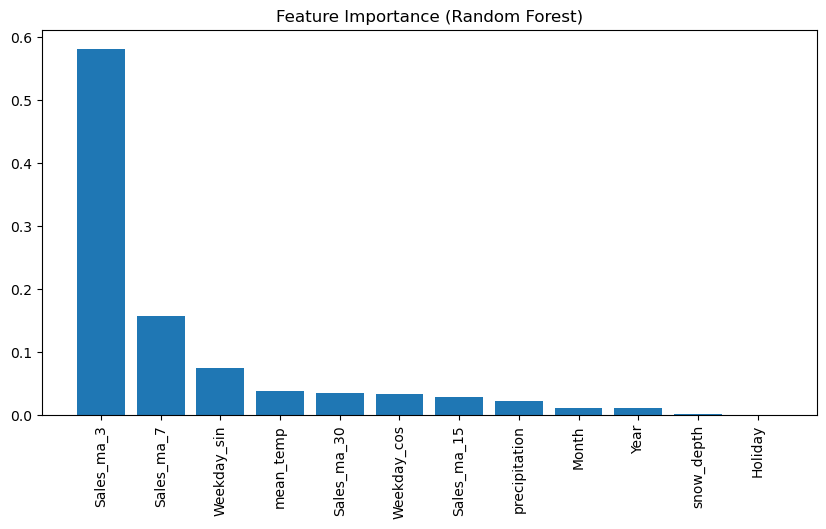

In [67]:
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns

indices = np.argsort(feature_importances)[::-1]
names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 5))
plt.title("Feature Importance (Random Forest)")

plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)

plt.show()